In [5]:
import torch
import torch.nn.functional as F 
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
from torch.utils.data import Dataset, DataLoader

# Hyperparameters


In [6]:
USE_CONDITION = False          # <- auf False setzen für unkonditioniert
d_model = 128
n_head = 4
n_layer = 4
d_ff = 512
dropout = 0.2
batch_size = 1024
eval_iters = 500
device = "cuda" if torch.cuda.is_available() else "cpu"

# Create dataset

Schritte:
1. Jeder wert kriegt ein eigenes lambda
2. füge den wert n_lambda mal einem string hinzu
3. shuffle die sequenz
4. erstelle solche strings N mal

In [7]:
values = np.arange(1, 5)
rates = {1: 6.0, 2: 3.0, 3: 1.5, 4: 0.7}
np.random.seed(42)

# einzelne sequenz mit poissonverteilten werten innerhalb der sequenz
def generate_poisson_string(values):
    count = 0
    seq = []
    for val in values:
        count = np.random.poisson(rates[val])
        for _ in range(count):
            seq.append(val)
        count=0
    seq = np.array(seq)
    np.random.shuffle(seq)
    return seq

# hänge N sequenzen aneinander und fülle immer bis zur maximalen länge mit 0 auf
def generate_dataset(N):
    sequences = [generate_poisson_string(values) for _ in range(N)]
    max_len = max(len(seq) for seq in sequences)
    padded_sequences = np.array([np.pad(seq, (0, max_len - len(seq)), mode='constant', constant_values=0) for seq in sequences])
    return padded_sequences

data = generate_dataset(1000000)

# Make list of sequences as list

In [8]:
def dataset_to_lol(dataset):
    seqs = []
    for row in dataset:
        zero_idx = np.argmax(row == 0) if np.any(row == 0) else len(row)
        seqs.append(row[:zero_idx])

    return seqs

seqs = dataset_to_lol(data)

In [9]:
# Vokabular der Ausgabewerte
vals = sorted({v for s in seqs for v in s})

# Spezielle Tokens
PAD_ID = 0 
BOS_ID = 1
EOS_ID = 2
offset = 3  # Start-ID für echte Werte
stoi = {v: i+offset for i,v in enumerate(vals)}
itos = {i+offset: v for i,v in enumerate(vals)}

vocab_size = offset + len(vals) 
max_len = max(len(s) for s in seqs)

def encode_example(seq):
    # Tokenize: BOS + seq + EOS, dann pad
    toks = [BOS_ID]
    toks += [stoi[v] for v in seq]
    toks.append(EOS_ID)
    # Ziel ist um 1 nach rechts geschoben
    attn_len = len(toks)
    pad_needed = ( (max_len + 2) - attn_len )
    toks += [PAD_ID] * pad_needed
    x = torch.tensor(toks[:-1], dtype=torch.long)  # inputs
    y = torch.tensor(toks[1:],  dtype=torch.long)  # targets
    return x, y

class SeqDataset(Dataset):
    def __init__(self, seqs):
        self.items = [encode_example(s) for s in seqs]
    def __len__(self): return len(self.items)
    def __getitem__(self, i): return self.items[i]

dataset = SeqDataset(seqs)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

train_size = int(0.8 * len(dataset))  
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, drop_last=True, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, drop_last=True, shuffle=False)

# Model

In [10]:
class CausalTransformer(nn.Module):
    def __init__(self, vocab_size, d_model, n_head, n_layer, d_ff, dropout):
        super().__init__()
        self.token_emb = nn.Embedding(vocab_size, d_model)
        self.pos_emb = nn.Parameter(torch.zeros(1, max_len + 1, d_model))  # +1 für BOS
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, 
                                                    nhead=n_head, 
                                                    dim_feedforward=d_ff, 
                                                    dropout=dropout,
                                                    batch_first=True,
                                                    activation='relu')
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layer, enable_nested_tensor=False)
        self.ff = nn.Linear(d_model, vocab_size)
        self.ln = nn.LayerNorm(d_model)

    def forward(self, x, targets=None):
        B, T = x.size() #Batch, num sequences/time
        h = self.token_emb(x) + self.pos_emb[:, :T, :]
        causal_mask = torch.triu(torch.ones(T, T, device=x.device), diagonal=1).bool()
        key_padding_mask = (x == PAD_ID)
        h = self.transformer(h, mask=causal_mask, src_key_padding_mask=key_padding_mask)
        h = self.ln(h)
        logits = self.ff(h)
            
        if targets is not None:
            B,T,C = logits.size()
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets, ignore_index=PAD_ID)
            return logits, loss
        else:
            loss=None

        return logits, loss

In [11]:
model = CausalTransformer(vocab_size, d_model, n_head, n_layer, d_ff, dropout).to(device)

# Training

In [12]:
@torch.no_grad()
def estimate_loss(model, train_loader, val_loader, eval_iters=500):
    out = {}
    model.eval()
    for split, loader in [('train', train_loader), ('val', val_loader)]:
        losses = []
        for i, (xb, yb) in enumerate(loader):
            if eval_iters is not None and i >= eval_iters:
                break
            else:
                xb, yb = xb.to(device), yb.to(device)
                _, loss = model(xb, yb)
                losses.append(loss.item())
        out[split] = sum(losses) / len(losses) if losses else float('inf')
    model.train()
    return out
            

def train_model(model, train_loader, val_loader, epochs, eval_iters=50, lr=1e-3):
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    model.to(device)

    #Per epoch losses
    train_losses = []
    val_losses =  []
    
    for epoch in tqdm(range(epochs)):
        metrics = estimate_loss(model, train_loader, val_loader, eval_iters=eval_iters)
        val_losses.append(metrics['val'])

        if epoch == epochs: break
    
        model.train()
        running_loss = 0.0
        for x, y in tqdm(train_loader):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            _, loss = model(x, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

    return train_losses, val_losses

In [13]:
trained_model = train_model(model, train_loader, val_loader, epochs=5, eval_iters=eval_iters, lr=1e-3)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/781 [00:00<?, ?it/s]

  0%|          | 0/781 [00:00<?, ?it/s]

  0%|          | 0/781 [00:00<?, ?it/s]

  0%|          | 0/781 [00:00<?, ?it/s]

  0%|          | 0/781 [00:00<?, ?it/s]

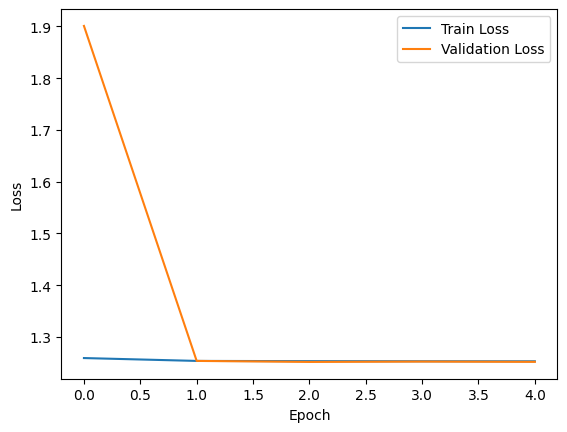

In [17]:
train_losses, val_losses = trained_model
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [16]:
model.train()
@torch.no_grad()
def sample_particle_sequences_parallel(model, n_seqs=50000, temperature=1.0, show_last_n=1, batch_size=512):
    # Teilchen-Dictionary
    particle_map = {1: 'γ', 2: 'e', 3: 'p', 4: 'P'}
    token_map = {PAD_ID: "PAD", BOS_ID: "BOS", EOS_ID: "EOS"}
    
    model.eval()
    all_sequences = []

    # Generiere in Batches für GPU-Effizienz
    for batch_start in tqdm(range(0, n_seqs, batch_size), desc="Generating sequences"):
        current_batch_size = min(batch_size, n_seqs - batch_start)
        
        # Batch von BOS-Tokens als Start
        idx = torch.tensor([[BOS_ID]] * current_batch_size, device=device)  # (batch_size, 1)
        sequences = [[] for _ in range(current_batch_size)]  # Für jeden Batch-Eintrag
        finished = torch.zeros(current_batch_size, dtype=torch.bool, device=device)
        
        # Detaillierte Ausgabe für bestimmte Sequenzen
        show_details_for = []
        for i in range(current_batch_size):
            global_idx = batch_start + i
            if global_idx >= (n_seqs - show_last_n):
                show_details_for.append(i)
        
        if show_details_for:
            print(f"\n=== Batch {batch_start//batch_size + 1}: Showing details for sequences {[batch_start + i + 1 for i in show_details_for]} ===")
        
        for step in range(max_len):
            # Parallelisierter Forward-Pass für den ganzen Batch
            logits, _ = model(idx)  # KORREKTUR: Tupel unpacking
            logits = logits[:, -1, :] / temperature  # (batch_size, vocab_size)
            
            # Parallelisiertes Sampling
            probs = F.softmax(logits, dim=-1)  # (batch_size, vocab_size)
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)
            
            # Überprüfe, ob für Debug-Sequenzen EOS generiert wurde
            show_eos_step = False
            if show_details_for:
                for detail_idx in show_details_for:
                    if not finished[detail_idx] and idx_next[detail_idx].item() == EOS_ID:
                        show_eos_step = True
                        break
            
            # Zeige Details für ausgewählte Sequenzen
            # Erweitert: Zeige auch EOS-Step (auch wenn > 10)
            if show_details_for and (step < 10 or show_eos_step):
                for detail_idx in show_details_for:
                    if not finished[detail_idx]:
                        seq_num = batch_start + detail_idx + 1
                        
                        # Spezielle Markierung für EOS-Step
                        if idx_next[detail_idx].item() == EOS_ID:
                            print(f"\n*** FINAL STEP {step + 1} (EOS generated) ***")
                        elif step < 10:
                            print(f"\nStep {step + 1}:")
                        else:
                            continue  # Skip andere Steps > 10 die kein EOS sind
                        
                        # Top-5 Wahrscheinlichkeiten für diese Sequenz
                        seq_probs = probs[detail_idx]
                        top_probs, top_indices = torch.topk(seq_probs, k=5)
                        
                        print("Top probabilities:")
                        for p, token_id in zip(top_probs.cpu().numpy(), top_indices.cpu().numpy()):
                            if token_id in itos:
                                particle_id = itos[token_id]
                                particle_char = particle_map.get(particle_id, f"?{particle_id}")
                                token_str = f"{particle_char}"
                            else:
                                token_str = token_map.get(token_id, f"Token {token_id}")
                            print(f"  {token_str}: {p:.3f}")
                        
                        # Gewähltes Token
                        chosen_id = idx_next[detail_idx].item()
                        if chosen_id in itos:
                            particle_id = itos[chosen_id]
                            particle_char = particle_map.get(particle_id, f"?{particle_id}")
                            print(f"Selected: {particle_char}")
                        elif chosen_id == EOS_ID:
                            print(f"Selected: EOS (sequence will end)")
                        else:
                            print(f"Selected: {token_map.get(chosen_id, f'Token {chosen_id}')}")
                        
                        # Aktuelle Sequenz
                        current_seq = ["BOS"]
                        for tok_id in sequences[detail_idx]:
                            if tok_id in itos:
                                particle_id = itos[tok_id]
                                particle_char = particle_map.get(particle_id, f"?{particle_id}")
                                current_seq.append(particle_char)
                            elif tok_id == EOS_ID:
                                current_seq.append("EOS")
                                break
                            else:
                                current_seq.append("?")
                        
                        # Füge neues Token hinzu
                        if chosen_id in itos:
                            particle_id = itos[chosen_id]
                            particle_char = particle_map.get(particle_id, f"?{particle_id}")
                            current_seq.append(particle_char)
                        elif chosen_id == EOS_ID:
                            current_seq.append("EOS")
                        
                        current_seq_str = "".join(current_seq)
                        print(f"Current sequence: {current_seq_str}")
            
            # Info über übersprungene Schritte
            elif show_details_for and step == 10:
                for detail_idx in show_details_for:
                    if not finished[detail_idx]:
                        print(f"\n... continuing generation silently until EOS or max_len ({max_len}) ...")
                        break
            
            # Update für alle Sequenzen im Batch
            for i in range(current_batch_size):
                if not finished[i]:
                    token_id = idx_next[i].item()
                    sequences[i].append(token_id)
                    
                    # Markiere als beendet wenn EOS
                    if token_id == EOS_ID:
                        finished[i] = True
            
            # Erweitere idx für alle Sequenzen
            idx = torch.cat([idx, idx_next], dim=1)  # (batch_size, seq_len+1)
            
            # Stoppe wenn alle Sequenzen beendet sind
            if finished.all():
                if show_details_for:
                    print(f"\nAll sequences in batch finished at step {step + 1}")
                break
        
        # Sammle Sequenzen aus diesem Batch
        for i, seq in enumerate(sequences):
            full_seq = [BOS_ID] + seq  # BOS + generierte Tokens
            all_sequences.append(full_seq)
        
        # Zeige finale Sequenzen für Details
        if show_details_for:
            for detail_idx in show_details_for:
                seq_num = batch_start + detail_idx + 1
                seq = sequences[detail_idx]
                
                print(f"\nFinal sequence {seq_num}:")
                final_seq = ["BOS"]
                particle_counts = {}
                
                for token_id in seq:
                    if token_id in itos:
                        particle_id = itos[token_id]
                        particle_char = particle_map.get(particle_id, f"?{particle_id}")
                        final_seq.append(particle_char)
                        particle_counts[particle_char] = particle_counts.get(particle_char, 0) + 1
                    elif token_id == EOS_ID:
                        final_seq.append("EOS")
                        break
                    else:
                        final_seq.append("?")
                
                sequence_str = "".join(final_seq)
                print(f"{sequence_str}")
                print(f"Total length: {len([t for t in seq if t != EOS_ID])} tokens + EOS")
                
                if particle_counts:
                    print("Particle composition:")
                    for particle, count in particle_counts.items():
                        print(f"  {particle}: {count}x")
            print("-" * 50)

    # Konvertiere zu finalen Sequenzen (ohne BOS, EOS, PAD)
    actual_seqs = []
    for seq in all_sequences:
        valid_tokens = [itos[t] for t in seq if t not in [BOS_ID, EOS_ID, PAD_ID] and t in itos]
        actual_seqs.append(valid_tokens)

    model.train()
    return actual_seqs

# Verwende die angepasste Version
actual_seqs = sample_particle_sequences_parallel(
    model, 
    n_seqs=50000, 
    show_last_n=1, 
    batch_size=512,
    temperature=1.0
)

Generating sequences:   0%|          | 0/98 [00:00<?, ?it/s]


=== Batch 98: Showing details for sequences [50000] ===

Step 1:
Top probabilities:
  γ: 0.541
  e: 0.265
  p: 0.135
  P: 0.059
  EOS: 0.000
Selected: p
Current sequence: BOSp

Step 2:
Top probabilities:
  γ: 0.534
  e: 0.267
  p: 0.138
  P: 0.061
  EOS: 0.000
Selected: e
Current sequence: BOSpe

Step 3:
Top probabilities:
  γ: 0.532
  e: 0.266
  p: 0.138
  P: 0.063
  EOS: 0.001
Selected: P
Current sequence: BOSpeP

Step 4:
Top probabilities:
  γ: 0.528
  e: 0.267
  p: 0.135
  P: 0.065
  EOS: 0.005
Selected: γ
Current sequence: BOSpePγ

Step 5:
Top probabilities:
  γ: 0.529
  e: 0.265
  p: 0.132
  P: 0.064
  EOS: 0.010
Selected: e
Current sequence: BOSpePγe

Step 6:
Top probabilities:
  γ: 0.520
  e: 0.264
  p: 0.129
  P: 0.063
  EOS: 0.023
Selected: e
Current sequence: BOSpePγee

Step 7:
Top probabilities:
  γ: 0.513
  e: 0.259
  p: 0.126
  P: 0.062
  EOS: 0.040
Selected: e
Current sequence: BOSpePγeee

Step 8:
Top probabilities:
  γ: 0.504
  e: 0.253
  p: 0.123
  P: 0.061
  EOS: 0.0